### Import

In [7]:
import optparse, os, sys, glob, re, pickle, time, datetime
sys.path.insert(0, "/home/maghoi/Magnus_pMHC/")
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import numpy as np
import pandas as pd
from IPython.display import HTML
def html(df):
    return(HTML(pd.DataFrame(df).to_html()))
#Pandas error "lazyConfigValue object has no attribute lower"
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

#FastAI functions
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.callbacks import *
from fastai.data_block import *
from fastai.metrics import *
from fastai.train import *
from fastai.utils import *
from fastai.core import *
from fastai.gen_doc import *

#Disable training progress bar (set next to learner fit)
import fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = fastprogress.force_console_behavior()
master_bar, progress_bar = master_bar, progress_bar


#Pytorch
import torch
import torch.nn as nn
import torch.utils.data as tdatautils

#Stats
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp

from sklearn import metrics, svm, datasets, random_projection
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, matthews_corrcoef, average_precision_score 
from sklearn.preprocessing import Normalizer, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

#Dataloaders and custom scripts
from allscripts import data_generator, data_generator_blosum, data_generator_filenames
from allscripts import upsample, generate_weights

### Load data (old)

In [287]:
filelist_loaded = []
filelist = glob.glob("/scratch/maghoi/pMHC_data/features5/*.csv"); len(filelist)
for i in range(0, len(filelist)):
    df = pd.read_csv(filelist[i])
    #df = df.drop(["Unnamed: 0", "Num", "pACC", "CNb"], axis = 1)

    #Convert categorical values (res + solvent acc cateogry) to string
    #df.iloc[:, 0:2] = df.iloc[:, 0:2].astype(int).astype(str)
    filelist_loaded.append(df)

### Load prepared .npy files

In [6]:
ix_train = 1080
ix_val = 256
ix_test = 128
data_size=1464

ix_test = data_size - ix_test
ix_val = ix_test - ix_val
ix_train = ix_val - ix_train

print(data_size)
print(ix_test)
print(ix_val)
print(ix_train)

1464
1336
1080
0


### Choice: Load by partition

In [63]:
!ls /home/maghoi/pMHC_data/02_Features/

m1.npy	names.pickle	target_y.pickle  X_mhc.pickle  X_tcr_a.pickle
m2.npy	PAR_VEC.pickle	X_mhc		 X_pep.pickle  X_tcr_b.pickle


In [3]:
p0 = glob.glob("/home/maghoi/pMHC_data/features9/*0p*")
p1 = glob.glob("/home/maghoi/pMHC_data/features9/*1p*")
p2 = glob.glob("/home/maghoi/pMHC_data/features9/*2p*")
p3 = glob.glob("/home/maghoi/pMHC_data/features9/*3p*")
p4 = glob.glob("/home/maghoi/pMHC_data/features9/*4p*")

train = p0 + p1 + p3 + p4
valid = p2
test = p4

len(train), len(valid), len(test), len(p0), len(p1), len(p2), len(p3), len(p4)


(1176, 288, 264, 336, 312, 288, 264, 264)

#### fetures 12

In [364]:
p0 = glob.glob("/home/maghoi/pMHC_data/features12/*0p*")
p1 = glob.glob("/home/maghoi/pMHC_data/features12/*1p*")
p2 = glob.glob("/home/maghoi/pMHC_data/features12/*2p*")
p3 = glob.glob("/home/maghoi/pMHC_data/features12/*3p*")
p4 = glob.glob("/home/maghoi/pMHC_data/features12/*4p*")

train = p0 + p1 + p2 + p3 
valid = p4
test = p4

len(train), len(valid), len(test), len(p0), len(p1), len(p2), len(p3), len(p4)


(1200, 264, 264, 336, 312, 288, 264, 264)

In [333]:
p0 = glob.glob("/home/maghoi/pMHC_data/features_11_old/*0p*")
p1 = glob.glob("/home/maghoi/pMHC_data/features_11_old/*1p*")
p2 = glob.glob("/home/maghoi/pMHC_data/features_11_old/*2p*")
p3 = glob.glob("/home/maghoi/pMHC_data/features_11_old/*3p*")
p4 = glob.glob("/home/maghoi/pMHC_data/features_11_old/*4p*")

train = p0 + p1 + p3 + p4
valid = p4
test = p4

len(train), len(valid), len(test), len(p0), len(p1), len(p2), len(p3), len(p4)


(1200, 264, 264, 336, 312, 288, 264, 264)

In [4]:
# Generate train, valid, test sets
Xt,yt, Xt_val, yt_val, Xt_test, yt_test = data_generator(train, valid, test)
X0, y0, X0_val, y0_val, X0_test, y0_test = Xt.copy(), yt.copy(), Xt_val.copy(), yt_val.copy(), Xt_test.copy(), yt_test.copy()

#Upsample
Xp, yp = upsample(Xt, yt)
Xp_val, yp_val = upsample(Xt_val, yt_val)
Xp_test, yp_test = upsample(Xt_test, yt_test)

(2007, 468, 56) (2007,)
(444, 468, 56) (444,)
(445, 468, 56) (445,)


In [49]:
from pandas import DataFrame
from IPython.display import HTML

In [ ]:
new_df = []
for i in range(len(Xp)):
    #check
    #Construct df to add
    energy_df = Xp.iloc[i][1:]
    energy_df = pd.DataFrame(np.vstack([np.array(energy_df)]*468))

### Choice: Load by original pMHC CNN data

In [9]:
X_mhc = pd.read_pickle("/home/maghoi/pMHC_data/02_Features/X_mhc.pickle")
X_pep = pd.read_pickle("/home/maghoi/pMHC_data/02_Features/X_pep.pickle")
X_tcr_a = pd.read_pickle("/home/maghoi/pMHC_data/02_Features/X_tcr_a.pickle")
X_tcr_b = pd.read_pickle("/home/maghoi/pMHC_data/02_Features/X_tcr_b.pickle")
PAR_VEC = pd.read_pickle("/home/maghoi/pMHC_data/02_Features/PAR_VEC.pickle")
target_y = pd.read_pickle("/home/maghoi/pMHC_data/02_Features/target_y.pickle")
names = pd.read_pickle("/home/maghoi/pMHC_data/02_Features/names.pickle")

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
def norm3d(df):
    train_data = df
    scaler = StandardScaler()
    num_instances, num_time_steps, num_features = train_data.shape
    train_data = np.reshape(train_data, newshape=(-1, num_features))
    train_data = scaler.fit_transform(train_data)
    train_data = np.reshape(train_data, newshape=(num_instances, num_time_steps, num_features))
    return train_data



In [11]:
#Load
X, y, X_val, y_val, X_test, y_test = data_generator_blosum(X_mhc, X_pep, X_tcr_a, X_tcr_b, target_y,
                                                           names, PAR_VEC, norm = False)

X0, y0, X0_val, y0_val, X0_test, y0_test = X.copy(), y.copy(), X_val.copy(), y_val.copy(), X_test.copy(), y_test.copy()

#Upsample
Xp, yp = upsample(X, y)
Xp_val, yp_val = upsample(X_val, y_val)
Xp_test, yp_test = upsample(X_test, y_test)



Train part [0, 1, 2, 3]
Val part 4
(716, 468, 13) (716,)
(338, 468, 13) (338,)
(318, 468, 13) (318,)


### Choice: Load by filename (standard, 1-hot aminos)

In [34]:
%%time
X,y, X_val, y_val, X_test, y_test = data_generator_filenames()
X0, y0, X0_val, y0_val, X0_test, y0_test = X.copy(), y.copy(), X_val.copy(), y_val.copy(), X_test.copy(), y_test.copy()

%%time
Xp, yp = upsample(X, y)
Xp_val, yp_val = upsample(X_val, y_val)
Xp_test, yp_test = upsample(X_test, y_test)

CPU times: user 637 ms, sys: 469 ms, total: 1.11 s
Wall time: 1.33 s


### Upsampled positives in sample

### 1.b Map the data to float/int as appropriate

Classification requires that targets are type INT

In [12]:
def to_torch_data(x,np_type,tch_type):
    return torch.from_numpy(x.astype(np_type)).to(tch_type)

X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))

train_ds = tdatautils.TensorDataset(X, y)
valid_ds = tdatautils.TensorDataset(X_val, y_val)
test_ds = tdatautils.TensorDataset(X_test, y_test)

X0, X0_val, X0_test = map(lambda x: to_torch_data(x,float,torch.float32),(X0, X0_val, X0_test))
y0, y0_val, y0_test = map(lambda x: to_torch_data(x,int,torch.int64),(y0, y0_val, y0_test))

train_ds0 = tdatautils.TensorDataset(X0, y0)
valid_ds0 = tdatautils.TensorDataset(X0_val, y0_val)
test_ds0 = tdatautils.TensorDataset(X0_test, y0_test)


In [13]:
def csvfile(n = 10, filename = "/home/maghoi/main/data/Stats1.csv"):
    df = pd.read_csv(filename)
    return df.tail(n)

In [14]:
def stats(ds = DatasetType.Valid):

    #Get raw predictions
    preds = learn.get_preds(ds)
    outputs = preds[0]
    targets = preds[1]

    #Find highest multi-class prediction (yes, this is wrong ...)
    yhat = []

    for i in range(len(outputs)):
        pred = outputs[i].tolist()
        pred = pred.index(max(pred))
        yhat.append(pred)

    #Pairwise comparison
    yhat = np.array(yhat)
    y_true = np.array(targets)
    y_scores = outputs[:, 1]
    y_scores_binary = np.where(y_scores > 0.5, 1, 0)

    correct = yhat == y_true
    auc = roc_auc_score(y_true, y_scores)
    mcc = matthews_corrcoef(y_true, y_scores_binary)
    f1 = f1_score(y_true, y_scores_binary, average="binary")
    avp = average_precision_score(y_true, y_scores)


    print("Correct:", round(sum(correct) / len(targets), 3))
    print("AUC", round(auc, 3))
    print("MCC", round(mcc, 3))
    print("F1", round(f1, 3))
    print("AVP", round(avp, 3))

    print("\nTn, fp, fn, tp")
    print(confusion_matrix(y_true, yhat))
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
    tpr = (tp / (tp+fn))
    tnr = (tn / (tn+fp))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    print("TPR:", round(tpr, 3))
    print("TNR:", round(tnr, 3))
    print("Prec:", round(precision, 3))
    print("Rec:", round(recall, 3))


In [15]:
def stat_graphs(ds = DatasetType.Valid):
    # Compute ROC curve and ROC area for each class
    preds = learn.get_preds(ds)
    yhat = preds[0][:, 1]
    ytrue = preds[1]
    yhat = np.array(yhat)
    
    stats()

    plt.scatter(yhat, ytrue, alpha=0.1) #Features 9 on parittions

    fpr = dict()
    tpr = dict()

    ytrue=np.array(ytrue)
    roc_auc = dict()
    fpr[0], tpr[0], steps = roc_curve(ytrue, yhat, pos_label=1, drop_intermediate=False)
    roc_auc[0] = auc(fpr[0], tpr[0])

    #Shared weights
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Correct: 0.758
AUC 0.679
MCC 0.202
F1 0.347
AVP 0.284

Tn, fp, fn, tp
[[183  37]
 [ 27  17]]
TPR: 0.386
TNR: 0.832
Prec: 0.315
Rec: 0.386


TypeError: 'numpy.float64' object is not callable

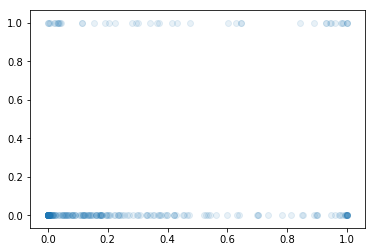

In [571]:
# Compute ROC curve and ROC area for each class
preds = learn.get_preds()
y_hat = np.array(preds[0][:, 1])
y_true = np.array(preds[1])
y_hat_binary = np.where(y_hat > 0.5, 1, 0)

correct = y_hat_binary == y_true
auc = roc_auc_score(y_true, y_hat)
mcc = matthews_corrcoef(y_true, y_hat_binary)
f1 = f1_score(y_true, y_hat_binary, average="binary")
avp = average_precision_score(y_true, y_hat)


print("Correct:", round(sum(correct) / len(y_true), 3))
print("AUC", round(auc, 3))
print("MCC", round(mcc, 3))
print("F1", round(f1, 3))
print("AVP", round(avp, 3))

print("\nTn, fp, fn, tp")
print(confusion_matrix(y_true, y_hat_binary))
tn, fp, fn, tp = confusion_matrix(y_true, y_hat_binary).ravel()
tpr = (tp / (tp+fn))
tnr = (tn / (tn+fp))
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("TPR:", round(tpr, 3))
print("TNR:", round(tnr, 3))
print("Prec:", round(precision, 3))
print("Rec:", round(recall, 3))

plt.scatter(y_hat, y_true, alpha=0.1) #Features 9 on parittions

fpr = dict()
tpr = dict()

y_true=np.array(y_true)
roc_auc = dict()
fpr[0], tpr[0], steps = roc_curve(y_true, y_hat_binary, pos_label=1, drop_intermediate=False)
roc_auc[0] = auc(fpr[0], tpr[0])

#Shared weights
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [17]:
now = time.time()
def stats_to_csv(start_time = time.time(), val_part = 4, test_part = int(), comment = "", ds=DatasetType.Valid):
    train_str = [0, 1, 2, 3, 4]
    val_str = val_part
    test_str = test_part
    
    stat_df = pd.DataFrame(columns = ["Comment", "Test", "Validation", "Training", "Correct", "AUC", "MCC", "AVP", "TPR", "TNR", "Confusion matrix", "Duration (s)", "Timestamp"])
    
    #Check for CSV file
    if not glob.glob("/home/maghoi/main/data/Stats1.csv"):
        stat_df.to_csv("/home/maghoi/main/data/Stats1.csv", mode = "w", header = True, index = False)
    
    #Remove val / test from training parts
    train_str.remove(val_str)
    if test_part != int():
        train_str.remove(test_str)
    
    #Get model performance
    data = record_stats(ds = ds)
    
    duration = round(time.time() - start_time)
    timestamp = str(datetime.datetime.now())
    
    #Add to stat_df and save to CSV
    row = [comment, test_str, val_str, train_str] + list(data) + [duration, timestamp]
    stat_df.loc[len(stat_df)] = row
    stat_df.to_csv("/home/maghoi/main/data/Stats1.csv", mode = "a", header = False, index = True)
    print(row)

### Model start

In [54]:
####
# CNN START
####

#Hyperparams for CNN

criterion = nn.CrossEntropyLoss()
in_channel = 1
n_hid = 56
epochs = 0
f = int(8)

batch_size = 32
drop_prob = 0.2

ks0 = 1
pad0 = int((ks0) / 2)
ks1 = 11
pad1 = int((ks1) / 2)
ks2 = 9
pad2 = int((ks2) / 2)
ks3 = 7
pad3 = int((ks3) / 2)
ks4 = 7
pad4 = int((ks4) / 2)
ks5 = 5
pad5 = int((ks5) / 2)
ks6 = 3
pad6 = int((ks6) / 2)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        #Batchnorm0
        self.a_norm_0 = nn.BatchNorm1d(in_channel)
        
        #Pad
        self.m_pad = nn.ConstantPad1d((160), 0)
        self.t_pad = nn.ConstantPad1d((118), 0)
        #self.p_pad = nn.ConstantPad1d((112, 113), 0)
        
        #Conv1
        self.m_conv_1 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.m_norm_1 = nn.BatchNorm1d(n_hid)
        self.m_max_1 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.m_drop_1 = nn.Dropout(p = drop_prob)
        self.m_ReLU_1 = nn.ReLU()

        self.t_conv_1 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.t_norm_1 = nn.BatchNorm1d(n_hid)
        self.t_max_1 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.t_drop_1 = nn.Dropout(p = drop_prob)
        self.t_ReLU_1 = nn.ReLU()

        #Conv2
        self.m_conv_2 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks2, padding = pad2)
        self.m_norm_2 = nn.BatchNorm1d(n_hid)
        self.m_max_2 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.m_drop_2 = nn.Dropout(p = drop_prob)
        self.m_ReLU_2 = nn.ReLU()
        self.m_norm_22 = nn.BatchNorm1d(n_hid)
        self.m_ReLU_22 = nn.ReLU()

        self.t_conv_2 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks2, padding = pad2)
        self.t_norm_2 = nn.BatchNorm1d(n_hid)
        self.t_max_2 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.t_drop_2 = nn.Dropout(p = drop_prob)
        self.t_ReLU_2 = nn.ReLU()


        #Conv3
        self.m_conv_3 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks3, padding = pad3)
        self.m_norm_3 = nn.BatchNorm1d(n_hid)
        self.m_max_3 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.m_drop_3 = nn.Dropout(p = drop_prob)
        self.m_ReLU_3 = nn.ReLU()

        self.t_conv_3 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks3, padding = pad3)
        self.t_norm_3 = nn.BatchNorm1d(n_hid)
        self.t_max_3 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.t_drop_3 = nn.Dropout(p = drop_prob)
        self.t_ReLU_3 = nn.ReLU()

        #Conv4
        self.m_conv_4 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks4, padding = pad4)
        self.m_norm_4 = nn.BatchNorm1d(n_hid)
        self.m_max_4 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.m_drop_4 = nn.Dropout(p = drop_prob)
        self.m_ReLU_4 = nn.ReLU()

        self.t_conv_4 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks4, padding = pad4)
        self.t_norm_4 = nn.BatchNorm1d(n_hid)
        self.t_max_4 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.t_drop_4 = nn.Dropout(p = drop_prob)
        self.t_ReLU_4 = nn.ReLU()

        #Conv5
        self.m_conv_5 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks5, padding = pad5)
        self.m_norm_5 = nn.BatchNorm1d(n_hid)
        self.m_max_5 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.m_drop_5 = nn.Dropout(p = drop_prob)
        self.m_ReLU_5 = nn.ReLU()

        self.t_conv_5 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks5, padding = pad5)
        self.t_norm_5 = nn.BatchNorm1d(n_hid)
        self.t_max_5 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.t_drop_5 = nn.Dropout(p = drop_prob)
        self.t_ReLU_5 = nn.ReLU()
        
        #Conv6
        self.m_conv_6 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks6, padding = pad6)
        self.m_norm_6 = nn.BatchNorm1d(n_hid)
        self.m_max_6 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.m_drop_6 = nn.Dropout(p = drop_prob)
        self.m_ReLU_6 = nn.ReLU()

        self.t_conv_6 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks6, padding = pad6)
        self.t_norm_6 = nn.BatchNorm1d(n_hid)
        self.t_max_6 = nn.AvgPool1d(kernel_size = 2, stride = 2)
        self.t_drop_6 = nn.Dropout(p = drop_prob)
        self.t_ReLU_6 = nn.ReLU()
        
        #Random projection module
        self.mrp_Linear = nn.Linear(in_features = (f)*n_hid, out_features = f*n_hid)
        self.mrp_norm = nn.BatchNorm1d(f*n_hid)
        self.mrp_ReLU = nn.ReLU()

        self.trp_Linear = nn.Linear(in_features = (f)*n_hid, out_features = f*n_hid)
        self.trp_norm = nn.BatchNorm1d(f*n_hid)
        self.trp_ReLU = nn.ReLU()

        self.mrp_prerpnorm = nn.BatchNorm1d(f*n_hid)
        self.trp_prerpnorm = nn.BatchNorm1d(f*n_hid)

        #Prediction module
        self.a_Linear0 = nn.Linear(in_features = f*n_hid, out_features = f*n_hid)
        self.a_BatchNorm = nn.BatchNorm1d(f*n_hid)
        self.a_ReLU = nn.ReLU(f*n_hid)

        #self.a_Dropout = nn.Dropout(p = 0.5)
        #self.a_linear = nn.Linear(in_features = f*n_hid, out_features = f*n_hid)
        #self.a_tanh1 = nn.Tanh()
        self.a_Linear2 = nn.Linear(in_features = f*n_hid, out_features = 2)
        #self.a_sigmoid = nn.Sigmoid()


    def forward(self, x):
        global ps
        bs0 = x.shape[0]
        x = x[:, :, 1:2]
    
        if ps: print("\nInput", x.shape)
        x = x.transpose(1, 2)
        if ps: print("Transpose", x.shape)
            
        #x = self.a_norm_0(x)
        
        mhcp = x[:, :, 0:192]
        tcr = x[:, :, 192:]
        pep = x[:, :, 181:192]
        #tcr = torch.cat((tcr, pep), dim = 2)
        if ps: print("Shapes", mhcp.shape, tcr.shape)

        mhcp0 = self.m_pad(mhcp)
        tcr0 = self.t_pad(tcr)
        if ps: print("Padded", mhcp0.shape, tcr0.shape)
            
        mhcp = self.m_norm_1(self.m_conv_1(mhcp0))
        tcr = self.t_norm_1(self.t_conv_1(tcr0))
        
        mhcp0 = self.m_max_1(self.m_drop_1(self.m_ReLU_1(mhcp)))
        tcr0 = self.t_max_1(self.t_drop_1(self.t_ReLU_1(tcr)))
        if ps: print("Conv1", mhcp.shape, tcr.shape)

        mhcp1 = self.m_max_2(mhcp0 + self.m_drop_2(self.m_ReLU_2(self.m_norm_2(self.m_conv_2(mhcp0)))))
        tcr1 = self.t_max_2(tcr0 + self.t_drop_2(self.t_ReLU_2(self.t_norm_2(self.t_conv_2(tcr0)))))
        if ps: print("Conv2", mhcp.shape, tcr.shape)

        mhcp0 = self.m_max_3(mhcp1 + self.m_drop_3(self.m_ReLU_3(self.m_norm_3(self.m_conv_3(mhcp1)))))
        tcr0 = self.t_max_3(tcr1 + self.t_drop_3(self.t_ReLU_3(self.t_norm_3(self.t_conv_3(tcr1)))))
        if ps: print("Conv3", mhcp.shape, tcr.shape)

        mhcp1 = self.m_max_4(mhcp0 + self.m_drop_4(self.m_ReLU_4(self.m_norm_4(self.m_conv_4(mhcp0)))))
        tcr1 = self.t_max_4(tcr0 + self.t_drop_4(self.t_ReLU_4(self.t_norm_4(self.t_conv_4(tcr0)))))
        if ps: print("Conv4", mhcp.shape, tcr.shape)

        mhcp0 = self.m_max_5(self.m_drop_5(self.m_ReLU_5(self.m_norm_5(self.m_conv_5(mhcp1)))))
        tcr0 = self.t_max_5(self.t_drop_5(self.t_ReLU_5(self.t_norm_5(self.t_conv_5(tcr1)))))
        if ps: print("Conv5", mhcp.shape, tcr.shape)

        mhcp1 = self.m_max_6(self.m_drop_6(self.m_ReLU_6(self.m_norm_6(self.m_conv_6(mhcp0)))))
        tcr1 = self.t_max_6(self.t_drop_6(self.t_ReLU_6(self.t_norm_6(self.t_conv_6(tcr0)))))
        if ps: print("Conv6", mhcp.shape, tcr.shape)

        #Flattening (Pre-RP)
        mhcp1 = mhcp1
        tcr1 = tcr1
        
        mhcp = mhcp1.view(bs0, sz0)
        tcr = tcr1.view(bs0, sz0)
        if ps: print("Views", mhcp.shape, tcr.shape)
        
        mhcp = self.mrp_ReLU(self.mrp_norm(self.mrp_Linear(mhcp)))
        tcr = self.trp_ReLU(self.trp_norm(self.trp_Linear(tcr)))
        
        #mhcp = mhcp + self.mrp_ReLU(self.mrp_norm(self.mrp_Linear(mhcp)))
        #tcr = tcr + self.trp_ReLU(self.trp_norm(self.trp_Linear(tcr)))
        if ps: print("Pre-rp", mhcp.shape, tcr.shape, m1.shape, m2.shape)
        
        #Random projection -> 640
        #mhcp = mhcp * m1[0:bs0]
        #tcr = tcr * m2[0:bs0]
        
        #remove batchnorm
        #mhcp = mhcp * self.mrp_prerpnorm(m1[0:bs0])
        #tcr = tcr * self.trp_prerpnorm(m2[0:bs0])
        if ps: print("RPed", mhcp.shape, tcr.shape, pep.shape)
        
        #mhcp = mhcp * m1[0:bs0]
        #tcr = tcr * m2[0:bs0]
        if ps: print("RPed", mhcp.shape, tcr.shape, pep.shape)
        
        #Element Matrix product
        allparts = mhcp * tcr
        if ps: print("Allparts", allparts.shape)
        #if ps: print("Allparts avgpool", allparts.shape)
        
        #Prediction module
        allparts = self.a_Linear2(allparts)
        if ps: print("Last", allparts.shape)
        ps = False
        
        x = allparts
        #print(x[-1])
        return x

In [25]:
def early_stopping_train(cycles=4, LR=16*[1e-02, 1e-01], epochs=16*[1],
                         val_part = int(4), test_part = int(),
                         comment=""):
    train_part=[0, 1, 2, 3, 4]
    ignore = 0
    ignore2 = 0
    LR = pd.Series(LR)
    now = time.time()
    
    for i in range(0, cycles):  
        #Break condition
        if ignore2 >= 2:
            print("Early stopping")
            break
        
        print("Cycle:", i+1, "/", cycles, "Epochs:", epochs[i], "LR:", LR[i*2], "->", LR[(i*2)+1])
        
        #Train model
        now = time.time()
        learn.fit_one_cycle(epochs[i], max_lr=slice(None, LR[i*2], LR[(i*2)+1]), wd = 0.01)
        
        #Save model and performance
        learn.save("/home/maghoi/main/data/models/temp_model_no_" + str(i))
        stats_to_csv(learn = learn, start_time = now, comment = comment, val_part = val_part, test_part = test_part)
        
        if i >= 1:
            #Check performance before vs after
            df = pd.read_csv("/home/maghoi/main/data/Stats1.csv")
            before = float(df.iloc[len(df)-(2+ignore)]["AUC"])
            after = float(df.iloc[len(df)-(1)]["AUC"])
            print(before, "vs", after)

            #Load model before if performance worse
            if before > after:
                print("Higher before, loading previous model ...")
                learn.load("/home/maghoi/main/data/models/temp_model_no_" + str(i - ignore))
                ignore += 1

                #Lower learning rate if no improvement in 1 cycle or 2 lower-LR cycles
                if ignore >= 1:
                    #val = 2
                    #LR = LR / val
                    #print("LR /", val)
                    ignore2 += 1   
            else:
                print("AUC higher after, continuing ...")

    #Cleanup
    filelist = glob.glob("/home/maghoi/main/data/models/temp_model_no_*")
    for file in filelist:
        pass
        #os.remove(file)
    
    #Save model
    train_part.remove(val_part)
    if test_part == int():
        test_part = "X"
    else:
        train_part.remove(test_part)

    test_str = str(test_part)
    val_str = str(val_part)
    train_str = "".join(map(str, train_part))

    filepath = "/home/maghoi/main/data/models/" + "T" + test_str + "V" + val_str + "_" + train_str
    
    learn.save(filepath)
    return(filepath)
    print("Done")



In [774]:
stat_df =pd.DataFrame(columns=["Correct", "AUC", "MCC", "AVP", "TPR", "TNR", "Confusion"])
stats = pd.DataFrame(test).transpose()
stats.columns = stat_df.columns
stat_df = stat_df.append(stats)

In [24]:
def simple_train(cycles=4, LR=10*[1e-02, 1e-01], epochs=10*[3],
                         val_part = int(4), test_part = int(),
                         skip = False):
    train_part=[0, 1, 2, 3, 4]
    LR = pd.Series(LR)
    
    #Skip validation
    if skip == True:
        learn.data.valid_dl = None
    
    #Train model
    for i in range(0, cycles):  
        print("Cycle:", i+1, "/", cycles, "Epochs:", epochs[i], "LR:", LR[i*2], "->", LR[(i*2)+1])
        now = time.time()
        learn.fit_one_cycle(epochs[i], max_lr=slice(None, LR[i*2], LR[(i*2)+1]), wd = 0.01)
    
    #Save model to filepath
    train_part.remove(val_part)
    if test_part == int():
        test_part = "X"
    else:
        train_part.remove(test_part)

    test_str = str(test_part)
    val_str = str(val_part)
    train_str = "".join(map(str, train_part))

    filepath = "/scratch/maghoi/data/3may/" + "T" + test_str + "V" + val_str + "_" + train_str
    learn.save(filepath)
    
    return(filepath)



In [662]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [808]:
p0 = glob.glob("/home/maghoi/pMHC_data/features12/*0p*")
p1 = glob.glob("/home/maghoi/pMHC_data/features12/*1p*")
p2 = glob.glob("/home/maghoi/pMHC_data/features12/*2p*")
p3 = glob.glob("/home/maghoi/pMHC_data/features12/*3p*")
p4 = glob.glob("/home/maghoi/pMHC_data/features12/*4p*")

train = p0 + p1 + p2 + p3
valid = p4
test = p4

len(train), len(valid), len(test), len(p0), len(p1), len(p2), len(p3), len(p4)

# Generate train, valid, test sets
Xt,yt, Xt_val, yt_val, Xt_test, yt_test = data_generator(train, valid, test)
X0, y0, X0_val, y0_val, X0_test, y0_test = Xt.copy(), yt.copy(), Xt_val.copy(), yt_val.copy(), Xt_test.copy(), yt_test.copy()

#Upsample
Xp, yp = upsample(Xt, yt)
Xp_val, yp_val = upsample(Xt_val, yt_val)
Xp_test, yp_test = upsample(Xt_test, yt_test)

def to_torch_data(x,np_type,tch_type):
    return torch.from_numpy(x.astype(np_type)).to(tch_type)

X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))

train_ds = tdatautils.TensorDataset(X, y)
valid_ds = tdatautils.TensorDataset(X_val, y_val)
test_ds = tdatautils.TensorDataset(X_test, y_test)

X0, X0_val, X0_test = map(lambda x: to_torch_data(x,float,torch.float32),(X0, X0_val, X0_test))
y0, y0_val, y0_test = map(lambda x: to_torch_data(x,int,torch.int64),(y0, y0_val, y0_test))

train_ds0 = tdatautils.TensorDataset(X0, y0)
valid_ds0 = tdatautils.TensorDataset(X0_val, y0_val)
test_ds0 = tdatautils.TensorDataset(X0_test, y0_test)

(1943, 468, 115) (1943,)
(456, 468, 115) (456,)
(452, 468, 115) (452,)


In [55]:
batch_size = 32
drop_prob = 0.2
ps = False
my_data_bunch = DataBunch.create(train_ds, valid_ds0, test_ds0, bs=batch_size)

#print(net)  
#print( 'trainable params: {}'.format(count_model_params(net)) )

net = Model().cuda()

sz = (896)/2
sz0 = int(896/2)
m1, m2 = generate_weights(32, sz, new = 0)

learn = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=[accuracy],
                     callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
                     wd = 0.01)

Loading m1, m2
torch.Size([32, 896]) torch.Size([32, 896])


In [85]:
#Simple FF

#Hyperparams for CNN

criterion = nn.CrossEntropyLoss()
in_channel = 468
n_hid = 1
epochs = 0
f = int(8)

batch_size = 32

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        #Batchnorm0
        #self.a_norm_0 = nn.BatchNorm1d(in_channel)
        
        #Prediction module
        self.a_Linear = nn.Linear(in_features = in_channel, out_features = 2)
        #self.a_BatchNorm = nn.BatchNorm1d(f*n_hid)
        #self.a_ReLU = nn.ReLU(f*n_hid)
        #self.a_Linear2 = nn.Linear(in_features = f*n_hid, out_features = 2)

    def forward(self, x):
        global ps
        bs0 = x.shape[0]
        x = x[:, :, 1:2]
    
        if ps: print("\nInput", x.shape)
        x = x.transpose(1, 2)
        if ps: print("Transpose", x.shape)
                    
        #mhcp = x[:, :, 0:192]
        #tcr = x[:, :, 192:]
        #pep = x[:, :, 181:192]
        #tcr = torch.cat((tcr, pep), dim = 2)
        #if ps: print("Shapes", mhcp.shape, tcr.shape)

            
        #mhcp = self.m_norm_1(self.m_conv_1(mhcp0))
        #tcr = self.t_norm_1(self.t_conv_1(tcr0))
        
       # allparts = mhcp * tcr
        #if ps: print("Allparts", allparts.shape)
        #if ps: print("Allparts avgpool", allparts.shape)
        
        #Prediction module
        allparts = self.a_Linear(x)
        if ps: print("Linear", allparts.shape)
        
        allparts = allparts.view(bs0, 2)
        if ps: print("Last", allparts.shape)
        ps = False
        
        x = allparts
        return x

batch_size = 32
#drop_prob = 0.2
ps = True
my_data_bunch = DataBunch.create(train_ds, valid_ds0, test_ds0, bs=batch_size)

#print(net)  
#print( 'trainable params: {}'.format(count_model_params(net)) )

net = Model().cuda()

#learn = Learner(my_data_bunch,
#                     net,
#                     opt_func=torch.optim.Adam,
#                     loss_func=criterion, metrics=[accuracy],
#                     callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
#                     wd = 0.01)

learn = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=[accuracy],
                     callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
                     wd = 0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


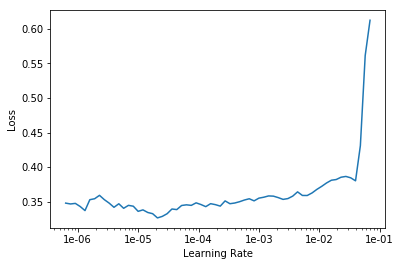

In [76]:
learn.lr_find()
learn.recorder.plot()

In [86]:
LR = [5e-03, 5e-02]*20
learn.fit_one_cycle(10, max_lr=slice(None, 5e-03, 5e-02), wd = 0.01)

epoch,train_loss,valid_loss,accuracy
1,0.884806,0.624836,0.727273
2,0.740356,0.785468,0.676768
3,0.697499,2.061788,0.353535
4,0.709483,2.135913,0.398990



Input torch.Size([32, 468, 1])
Transpose torch.Size([32, 1, 468])
Linear torch.Size([32, 1, 2])
Last torch.Size([32, 2])
Epoch 5: early stopping


Correct: 0.747
AUC 0.742
MCC 0.364
F1 0.479
AVP 0.356

Tn, fp, fn, tp
[[125  40]
 [ 10  23]]
TPR: 0.697
TNR: 0.758
Prec: 0.365
Rec: 0.697


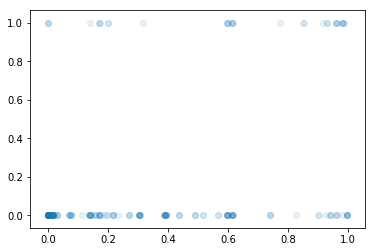

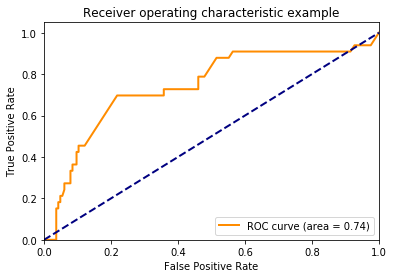

In [77]:
stat_graphs()

In [68]:
## simple learn
SETS = 20
i = 20
cycles = SETS*1
epochs = 2*[1]+(SETS-2)*[1]
LR = [1e-02, 1e-01, 1e-02, 1e-01, 1e-03, 5e-02, 1e-03, 5e-02]*20

#filepath = simple_train(cycles = SETS*4, epochs = SETS*4*[1], LR = LR, val_part = i, skip = False)
filepath = early_stop2(learn = learn, cycles = cycles, val_part = i)

Cycle: 1 / 80 Epochs: 1 LR: 0.01 -> 0.1


epoch,train_loss,valid_loss,accuracy
1,0.903367,1.103174,0.520202



Input torch.Size([32, 468, 1])
Transpose torch.Size([32, 1, 468])
Linear torch.Size([32, 1, 2])
Last torch.Size([32, 2])
Cycle: 2 / 80 Epochs: 1 LR: 0.01 -> 0.1


epoch,train_loss,valid_loss,accuracy
1,0.660808,1.275151,0.439394


Cycle: 3 / 80 Epochs: 1 LR: 0.001 -> 0.05


epoch,train_loss,valid_loss,accuracy
1,0.484116,0.839472,0.585859


Cycle: 4 / 80 Epochs: 1 LR: 0.001 -> 0.05


epoch,train_loss,valid_loss,accuracy
1,0.465844,0.989092,0.444444


Cycle: 5 / 80 Epochs: 1 LR: 0.01 -> 0.1


epoch,train_loss,valid_loss,accuracy
1,0.581584,0.505967,0.803030


Cycle: 6 / 80 Epochs: 1 LR: 0.01 -> 0.1


epoch,train_loss,valid_loss,accuracy
1,1.163464,1.381439,0.464646


Cycle: 7 / 80 Epochs: 1 LR: 0.001 -> 0.05


epoch,train_loss,valid_loss,accuracy
1,0.552957,0.719480,0.595960


Cycle: 8 / 80 Epochs: 1 LR: 0.001 -> 0.05


epoch,train_loss,valid_loss,accuracy
1,0.438701,0.968021,0.545455


Cycle: 9 / 80 Epochs: 1 LR: 0.01 -> 0.1


epoch,train_loss,valid_loss,accuracy
1,0.480461,0.881570,0.530303


Cycle: 10 / 80 Epochs: 1 LR: 0.01 -> 0.1


epoch,train_loss,valid_loss,accuracy


KeyboardInterrupt: 

Correct: 0.814
AUC 0.695
MCC 0.151
F1 0.222
AVP 0.31

Tn, fp, fn, tp
[[208  12]
 [ 37   7]]
TPR: 0.159
TNR: 0.945
Prec: 0.368
Rec: 0.159


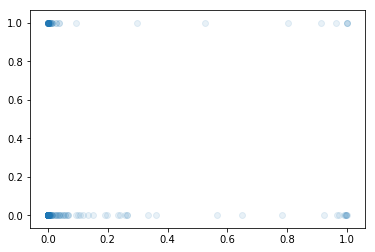

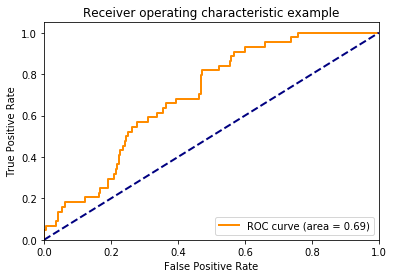

In [819]:
stat_graphs()

In [78]:
def early_stop2(learn=learn, cycles=16, LR=16*[1e-02, 1e-01, 5e-03, 5e-02], epochs=16*[1],
                         val_part = int(4), test_part = int(),
                         comment="", outdir = "/scratch/maghoi/data/models/"):
    train_part=[0, 1, 2, 3, 4]
    LR = pd.Series(LR)
    now = time.time()
    stat_df = pd.DataFrame(columns=["Correct", "AUC", "MCC", "AVP", "TPR", "TNR", "Confusion"])
    
    #Create outidr
    os.makedirs(outdir, exist_ok = True)
    os.makedirs(outdir+"/saved/", exist_ok = True)
    
    for i in range(0, cycles):  

        print("Cycle:", i+1, "/", cycles, "LR:", LR[i*2], "->", LR[(i*2)+1])
        
        #Train model
        now = time.time()
        learn.fit_one_cycle(epochs[i], max_lr=slice(None, LR[i*2], LR[(i*2)+1]), wd = 0.01)
        if i == 0:
            print("Saving initial model ...", outdir+"temp_model")
            learn.save(outdir + "temp_model")
        
        if i >= 1:
            #Check performance before vs after
            stats = pd.DataFrame(record_stats()).transpose()
            stats.columns = stat_df.columns
            stat_df = stat_df.append(stats)
            
            #df = pd.read_csv("/home/maghoi/main/data/Stats1.csv")
            before = float(stat_df.iloc[len(stat_df)-(2)]["MCC"])
            after = float(stat_df.iloc[len(stat_df)-(1)]["MCC"])
            print("Before;", before, "vs", "After:", after)

            #Load model before if performance worse
            if after > before:
                print("MCC higher, saving ...")
                learn.save(outdir + "temp_model")
    #Save model
    train_part.remove(val_part)
    if test_part == int():
        test_part = "0"
    else:
        train_part.remove(test_part)

    test_str = str(test_part)
    val_str = str(val_part)
    train_str = "".join(map(str, train_part))

    filepath = outdir+"saved/" + "T" + test_str + "V" + val_str + "_" + train_str
    learn.load(outdir+"temp_model")
    learn.save(filepath)
    
    filelist = glob.glob(outdir + "temp_model*")
    if filelist:
        print("Removing", filelist[0])
        os.remove(filelist[0])
    else:
        print("No file found????")
    
    return(filepath)
    print("Done")



In [823]:
pd.read_csv("/home/maghoi/Magnus_pMHC/CSV/CSV_new.csv").columns[4:14]

Index(['Correct', 'AUC', 'MCC', 'F1', 'AVP', 'TPR', 'TNR', 'Prec', 'Rec',
       'Confusion matrix'],
      dtype='object')

In [816]:
glob.glob("/scratch/maghoi/data/models/temp_model*")

['/scratch/maghoi/data/models/temp_model']

Correct: 0.754
AUC 0.681
MCC 0.089
F1 0.235
AVP 0.255

Tn, fp, fn, tp
[[189  31]
 [ 34  10]]
TPR: 0.227
TNR: 0.859
Prec: 0.244
Rec: 0.227


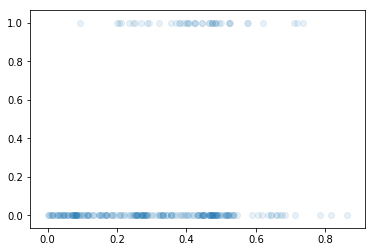

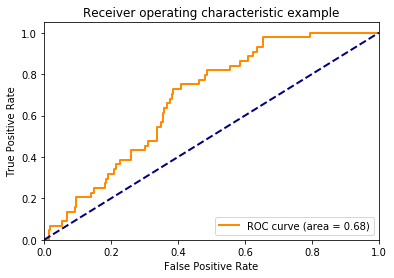

In [813]:
stat_graphs()

Correct: 0.86
AUC 0.853
MCC 0.5
F1 0.584
AVP 0.553

Tn, fp, fn, tp
[[256  24]
 [ 23  33]]
TPR: 0.589
TNR: 0.914
Prec: 0.579
Rec: 0.589


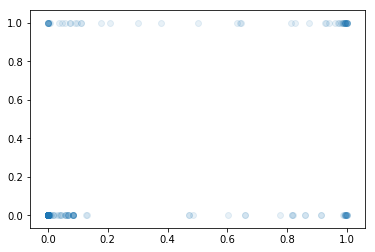

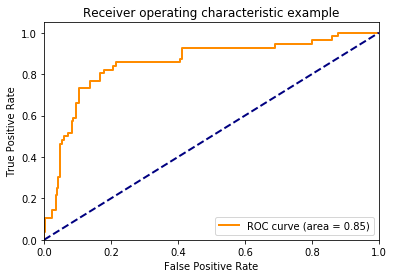

In [787]:
stat_graphs()

In [284]:
df = pd.DataFrame(index = range(0,7))

#simple learn on BLOSUM
for i in range(0, 5):
    #Load
    X, y, X_val, y_val, X_test, y_test = data_generator_blosum(X_mhc, X_pep, X_tcr_a, X_tcr_b, target_y,
                                                               names, PAR_VEC, norm = True, val_part = i)

    X0, y0, X0_val, y0_val, X0_test, y0_test = X.copy(), y.copy(), X_val.copy(), y_val.copy(), X_test.copy(), y_test.copy()

    #Upsample
    Xp, yp = upsample(X, y)
    Xp_val, yp_val = upsample(X_val, y_val)
    Xp_test, yp_test = upsample(X_test, y_test)
    
    batch_size = 32
    drop_prob = 0.2
    ps = False
    my_data_bunch = DataBunch.create(train_ds, valid_ds0, test_ds0, bs=batch_size)
    net = Model().cuda()

    sz = (896)
    sz0 = int(896)
    m1, m2 = generate_weights(32, sz, new = 0)

    learn = Learner(my_data_bunch,
                         net,
                         opt_func=torch.optim.Adam,
                         loss_func=criterion, metrics=[accuracy],
                         callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
                         wd = 0.01)

    SETS = 20
    cycles = SETS*20
    epochs = 2*[1]+(SETS-2)*[1]
    #LR = [1e-02, 1e-01, 1e-02, 1e-01, 1e-02, 1e-01]+(SETS-3)*[5e-03, 5e-02]
    LR = [1e-02, 1e-01, 1e-02, 1e-01, 5e-03, 5e-02, 1e-03, 1e-02]+(SETS-4)*[5e-03, 5e-02]

    LR = [1e-02, 1e-01, 1e-02, 1e-01, 5e-03, 5e-02, 1e-03, 1e-02]+(SETS-4)*[5e-03, 5e-02]

    #filepath = simple_train(cycles = SETS*4, epochs = SETS*4*[1], LR = [1e-02, 1e-01, 1e-02, 1e-01, 1e-03, 5e-02, 1e-03, 5e-02], val_part = i, skip = False)
    filepath = simple_train(learn = learn, cycles = cycles, epochs = epochs, LR = LR, val_part = i, skip = False)
    
    stats_to_csv(val_part = i, comment = "blosum")

['4sblosum', 0, 4, [0, 1, 2, 3], 0.662, 0.712, 0.126, 0.33, 0.455, 0.703, array([[116,  49],
       [ 18,  15]]), 2002, '2019-05-22 14:36:54.246746']


In [16]:
def set_baseline_model(n = 3, epochs = 3, LR = [1e-02, 1e-01], learn = learn):
    stat_df = pd.DataFrame(columns = ["Filename", "Correct", "AUC", "MCC", "AVP", "TPR", "TNR", "Confusion matrix"])

    for i in range(0, n):
        print("Run", i+1, "/", n)
        net = Model().cuda()
        learn = Learner(my_data_bunch,
                             net,
                             opt_func=torch.optim.Adam,
                             loss_func=criterion, metrics=[accuracy],
                             callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
                             wd = 0.01)
        learn.fit_one_cycle(epochs, max_lr = slice(None, LR[0], LR[1]), wd = 0.01)
        
        path = "/home/maghoi/main/data/models/"
        filename = "Baseline" + str(i)
        learn.save(path+filename)

        row = [filename] + list(record_stats(ds = DatasetType.Valid, learn = learn))
        stat_df.loc[len(stat_df)] = row

    #Load best model:
    filename = "/home/maghoi/main/data/models/" + str(stat_df.loc[stat_df["MCC"].idxmax(), "Filename"])
    print(stat_df)
    print("Returning model", path+filename+".pth")
    return stat_df, filename+".pth"

In [17]:
!mkdir -p /scratch/maghoi/data/3may
!ls /scratch/maghoi/data/3may

T0V1_234.pth  T1V0_234.pth  T2V0_134.pth  T3V0_124.pth	T4V0_123.pth
T0V2_134.pth  T1V2_034.pth  T2V1_034.pth  T3V1_024.pth	T4V1_023.pth
T0V3_124.pth  T1V3_024.pth  T2V3_014.pth  T3V2_014.pth	T4V2_013.pth
T0V4_123.pth  T1V4_023.pth  T2V4_013.pth  T3V4_012.pth	T4V3_012.pth


In [ ]:
#Cross-val function
data = [p0, p1, p2, p3, p4]

partitions = [0, 1, 2, 3, 4]
run = 0

for i in partitions:
    partitions = [0, 1, 2, 3, 4]
    val_part = data[i]
    partitions.remove(i)

    train_part = []
    train_i3 = []
    for i3 in partitions:
        train_part += data[i3]
        train_i3.append(i3)

    train_i3 = "".join(map(str, train_i3))
    run += 1
    print("Run", run, "/ 5 ...", "Val", i, "Train", train_i3)

    train = train_part
    valid = val_part
    test = val_part


    #Load data
    X, y, X_val, y_val, _, _ = data_generator(train, valid, test)
    X0, y0, X0_val, y0_val = X.copy(), y.copy(), X_val.copy(), y_val.copy()

    #Upsample
    X, y = upsample(X, y)

    X = to_torch_data(X,float,torch.float32)
    y = to_torch_data(y,int,torch.int64)

    X0_val = to_torch_data(X0_val,float,torch.float32)
    y0_val = to_torch_data(y0_val,int,torch.int64)

    #Create Tensor Dataset and FastAI databunch
    train_ds = tdatautils.TensorDataset(X, y)
    valid_ds0 = tdatautils.TensorDataset(X0_val, y0_val)
    dummy_ds = tdatautils.TensorDataset(X0_val[0:2], y0_val[0:2])

    #dummy_data_bunch = DataBunch.create(train_ds, dummy_ds, bs=batch_size)
    my_data_bunch = DataBunch.create(train_ds, valid_ds0, bs=batch_size)

    #Initialize model
    net = Model().cuda()
    learn = Learner(my_data_bunch, net,
                         opt_func=torch.optim.Adam,
                         loss_func=criterion, metrics=[accuracy],
                         wd = 0.01)

    #Run model
    filepath = simple_train(cycles = 4, epochs = 4*[1], LR = [1e-02, 1e-01, 1e-02, 1e-01, 1e-03, 5e-02, 1e-03, 5e-02],
                                    learn = learn, val_part = i, skip = False)
   # filepath = simple_train(cycles = 1, epochs = 1*[1], LR = 1*[1e-02, 1e-01],
   #                                 learn = learn, val_part = i, skip = False)

    #Stats
    learn = Learner(my_data_bunch,
                         net,
                         opt_func=torch.optim.Adam,
                         loss_func=criterion, metrics=[accuracy],
                         callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
                         wd = 0.01)
    learn.load(filepath)
    #learn.data.valid_dl = torch.utils.data.dataloader.DataLoader(valid_ds0.cuda(), batch_size=32, num_workers=16)
    stats_to_csv(comment = "latest"+i4, val_part = i, ds = DatasetType.Valid, learn = learn)


Run 1 / 5 ... Val 0 Train 1234
(1864, 468, 56) (1864,)
Cycle: 1 / 4 Epochs: 1 LR: 0.01 -> 0.1


epoch,train_loss,valid_loss,accuracy


In [150]:
#Neated cross-val function
t0 = [13,14,15]
t1 = [1,2,3]
t2 = [4,5,6]
t3 = [7,8,9]
t4 = [10, 11, 12]

data = [t0, t1, t2, t3, t4]

partitions = [0, 1, 2, 3, 4]
for i in partitions:
    partitions = [0, 1, 2, 3, 4]
    test_part = data[i]
    partitions.remove(i)
    
    for i2 in partitions:
        remaining = partitions.copy()
        val_part = data[i2]
        remaining.remove(i2)
        
        train = []
        train_i3 = []
        for i3 in remaining:
            train += data[i3]
            train_i3.append(i3)
            
        train_i3 = "".join(map(str, train_i3))
        print("Test", i, "Val", i2, "Train", train_i3)
        #print("Test", test_part, "Val", val_part, "Train", train)

Test 0 Val 1 Train 234
Test 0 Val 2 Train 134
Test 0 Val 3 Train 124
Test 0 Val 4 Train 123
Test 1 Val 0 Train 234
Test 1 Val 2 Train 034
Test 1 Val 3 Train 024
Test 1 Val 4 Train 023
Test 2 Val 0 Train 134
Test 2 Val 1 Train 034
Test 2 Val 3 Train 014
Test 2 Val 4 Train 013
Test 3 Val 0 Train 124
Test 3 Val 1 Train 024
Test 3 Val 2 Train 014
Test 3 Val 4 Train 012
Test 4 Val 0 Train 123
Test 4 Val 1 Train 023
Test 4 Val 2 Train 013
Test 4 Val 3 Train 012


In [145]:
#Nested cross-val function
data = [p0, p1, p2, p3, p4]

run = 0
partitions = [0, 1, 2, 3, 4]
for i in partitions:
    partitions = [0, 1, 2, 3, 4]
    test_part = data[i]
    partitions.remove(i)
    
    for i2 in partitions:
        remaining = partitions.copy()
        val_part = data[i2]
        remaining.remove(i2)
        
        train = []
        train_i3 = []
        for i3 in remaining:
            train += data[i3]
            train_i3.append(i3)
            
        train_i3 = "".join(map(str, train_i3))
        run += 1
        print(run, "/ 20", " ... Test", i, "Val", i2, "Train", train_i3)
        #print("Test", test_part, "Val", val_part, "Train", train)
        
        train = train
        valid = val_part
        test = test_part
        
        #Load data
        Xt,yt, Xt_val, yt_val, Xt_test, yt_test = data_generator(train, valid, test)
        X0, y0, X0_val, y0_val, X0_test, y0_test = Xt.copy(), yt.copy(), Xt_val.copy(), yt_val.copy(), Xt_test.copy(), yt_test.copy()

        #Upsample
        Xp, yp = upsample(Xt, yt)
        Xp_val, yp_val = upsample(Xt_val, yt_val)
        Xp_test, yp_test = upsample(Xt_test, yt_test)

        X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
        y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))
        X0, X0_val, X0_test = map(lambda x: to_torch_data(x,float,torch.float32),(X0, X0_val, X0_test))
        y0, y0_val, y0_test = map(lambda x: to_torch_data(x,int,torch.int64),(y0, y0_val, y0_test))

        train_ds = tdatautils.TensorDataset(X, y)
        valid_ds0 = tdatautils.TensorDataset(X0_val, y0_val)
        test_ds0 = tdatautils.TensorDataset(X0_test, y0_test)
        
        #Run model
        my_data_bunch = DataBunch.create(train_ds, valid_ds0, test_ds0, bs=batch_size)
        net = Model().cuda()
        learn = Learner(my_data_bunch,
                             net,
                             opt_func=torch.optim.Adam,
                             loss_func=criterion, metrics=[accuracy],
                             callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
                             wd = 0.01)

        #Stats
        filepath = simple_train(cycles = 4, epochs = 4*[1], LR = [1e-02, 1e-01, 1e-02, 1e-01, 1e-03, 5e-02, 1e-03, 5e-02],
                                        learn = learn, comment = "NCV",
                                       val_part = 3, test_part = 4)

        learn.load(filepath)
        stats_to_csv(comment = "22may"+str(i), val_part = i2, test_part = i, ds = DatasetType.Valid, learn = learn)
        stats_to_csv(comment = "22may"+str(i), val_part = i2, test_part = i, ds = DatasetType.Test, learn = learn)

['NCV', 4, 3, [0, 1, 2], 0.701, 0.58, -0.068, 0.184, 0.114, 0.818, array([[180,  40],
       [ 39,   5]]), 5528, '2019-05-03 22:51:44.231062']


In [25]:
csvfile(40)

NameError: name 'csvfile' is not defined

In [84]:
train = p0 + p1 + p2
valid = p3
test = p4

len(train), len(valid), len(test), len(p0), len(p1), len(p2), len(p3), len(p4)

# Generate train, valid, test sets
Xt,yt, Xt_val, yt_val, Xt_test, yt_test = data_generator(train, valid, test)
X0, y0, X0_val, y0_val, X0_test, y0_test = Xt.copy(), yt.copy(), Xt_val.copy(), yt_val.copy(), Xt_test.copy(), yt_test.copy()

#Upsample
Xp, yp = upsample(Xt, yt)
Xp_val, yp_val = upsample(Xt_val, yt_val)
Xp_test, yp_test = upsample(Xt_test, yt_test)

X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))

#X = map(lambda x: to_torch_data(x,float,torch.float32),Xp)
#y = map(lambda x: to_torch_data(x,int,torch.int64),yp)

X0, X0_val, X0_test = map(lambda x: to_torch_data(x,float,torch.float32),(X0, X0_val, X0_test))
y0, y0_val, y0_test = map(lambda x: to_torch_data(x,int,torch.int64),(y0, y0_val, y0_test))

train_ds = tdatautils.TensorDataset(X, y)
#valid_ds = tdatautils.TensorDataset(X_val, y_val)
#test_ds = tdatautils.TensorDataset(X_test, y_test)

train_ds0 = tdatautils.TensorDataset(X0, y0)
valid_ds0 = tdatautils.TensorDataset(X0_val, y0_val)
test_ds0 = tdatautils.TensorDataset(X0_test, y0_test)


(1537, 468, 56) (1537,)
(462, 468, 56) (462,)
(452, 468, 56) (452,)


In [77]:
!rm /home/maghoi/main/data/models/*

In [78]:
#Reloading model because wtf pytorch
my_data_bunch = DataBunch.create(train_ds, valid_ds0, test_ds0, bs=batch_size)
net = Model().cuda()
learn = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=[accuracy],
                     callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
                     wd = 0.01)

#Stats
filepath = simple_train(cycles = 4, epochs = 4*[1], LR = [1e-02, 1e-01, 1e-02, 1e-01, 1e-03, 5e-02, 1e-03, 5e-02],
                                learn = learn, comment = "NCV",
                               val_part = 3, test_part = 4)

learn.load(filepath)
i = 1
stats_to_csv(comment = "3may"+str(i), val_part = 3, test_part = 4, ds = DatasetType.Valid, learn = learn)
stats_to_csv(comment = "3may"+str(i), val_part = 3, test_part = 4, ds = DatasetType.Test, learn = learn)

Cycle: 1 / 4 Epochs: 1 LR: 0.01 -> 0.1


epoch,train_loss,valid_loss,accuracy
1,0.524657,0.606094,0.791667


Cycle: 2 / 4 Epochs: 1 LR: 0.01 -> 0.1


epoch,train_loss,valid_loss,accuracy
1,0.377113,0.660827,0.662879


Cycle: 3 / 4 Epochs: 1 LR: 0.001 -> 0.05


epoch,train_loss,valid_loss,accuracy
1,0.276635,0.604493,0.685606


Cycle: 4 / 4 Epochs: 1 LR: 0.001 -> 0.05


epoch,train_loss,valid_loss,accuracy
1,0.236375,0.652951,0.681818


In [82]:
learn.load(filepath)
i = 1
stats_to_csv(comment = "3may"+str(i), val_part = 3, test_part = 4, ds = DatasetType.Valid, learn = learn)
stats_to_csv(comment = "3may"+str(i), val_part = 3, test_part = 4, ds = DatasetType.Test, learn = learn)


['3may1', 4, 3, [0, 1, 2], 0.727, 0.672, 0.036, 0.249, 0.205, 0.832, array([[183,  37],
       [ 35,   9]]), 563, '2019-05-03 21:28:58.578257']


In [83]:
csvfile(5)

,Comment,Test,Validation,Training,Correct,AUC,MCC,AVP,TPR,TNR,Confusion matrix,Duration (s),Timestamp
0,3may1,4,3,"[0, 1, 2]",0.716,0.621,-0.072,0.206,0.091,0.841,[[185 35]\n [ 40 4]],476,2019-05-03 21:27:31.837376
0,3may1,4,3,"[0, 1, 2]",0.811,0.678,0.280,0.453,0.364,0.900,[[198 22]\n [ 28 16]],536,2019-05-03 21:28:32.405542
0,3may1,4,3,"[0, 1, 2]",0.716,0.621,-0.072,0.206,0.091,0.841,[[185 35]\n [ 40 4]],539,2019-05-03 21:28:35.056715
0,3may1,4,3,"[0, 1, 2]",0.682,0.565,0.106,0.186,0.386,0.741,[[163 57]\n [ 27 17]],560,2019-05-03 21:28:56.132863
0,3may1,4,3,"[0, 1, 2]",0.727,0.672,0.036,0.249,0.205,0.832,[[183 37]\n [ 35 9]],563,2019-05-03 21:28:58.578257


In [408]:
learn.load(filepath)
stats_to_csv(comment = "0learn"+str(i), val_part = 3, test_part = 4, learn = learn, ds = DatasetType.Valid)
stats_to_csv(comment = "0learn test"+str(i), val_part = 3, test_part = 4, learn = learn, ds = DatasetType.Test)

['0learn test4', 4, 3, [0, 1, 2], 0.731, 0.639, 0.179, 0.238, 0.409, 0.795, array([[175,  45],
       [ 26,  18]]), 5126, '2019-05-03 16:28:11.950583']


In [602]:
#CSV df function
for i in range(0, 5):
    #Define partitions
    train_str = [0,1,2,3,4]
    partitions = [p0, p1, p2, p3, p4]
    train_part = []
    val_part = []

    #Set val and train parts
    val_part = partitions[i]
    del partitions[i]
    
    for i2 in range(len(partitions)):
        train_part.extend(partitions[i2])
        
    val_str = i
    del train_str[i]
    
    print("Val", str(val_str))
    print("Train", str(train_str))
    now = time.time()
    
    #Set up databunch
    train = train_part
    valid = val_part
    test = p4 #irrelevant

    Xt, yt, Xt_val, yt_val, Xt_test, yt_test = data_generator(train, valid, test)
    X0_val, y0_val, X0_test, y0_test = Xt_val.copy(), yt_val.copy(), Xt_test.copy(), yt_test.copy()
    
    #Upsample
    Xp, yp = upsample(Xt, yt)

    #Set to int / float values
    X = to_torch_data(Xp,float,torch.float32)
    y = to_torch_data(yp,int,torch.int64)

    X0_val, X0_test = map(lambda x: to_torch_data(x,float,torch.float32),(X0_val, X0_test))
    y0_val, y0_test = map(lambda x: to_torch_data(x,int,torch.int64),(y0_val, y0_test))

    train_ds = tdatautils.TensorDataset(X, y)
    valid_ds0 = tdatautils.TensorDataset(X0_val, y0_val)

    #Setup model
    my_data_bunch = DataBunch.create(train_ds, valid_ds0, bs=batch_size)
    net = Model().cuda()
    learn = Learner(my_data_bunch,
                         net,
                         opt_func=torch.optim.Adam,
                         loss_func=criterion, metrics=[accuracy],
                        wd = 0.01)
    
    #Train
    learn.fit_one_cycle(4, max_lr=slice(None, 1e-02, 1e-01), wd = 0.01)
    
    #Stats
    data = record_stats()
    duration = round(time.time() - now)
    timestamp = str(datetime.datetime.now())
    
    row = [val_str, train_str] + list(data) + [duration, timestamp]
    stat_df.loc[len(stat_df)] = row
    print(row)

[4, [0, 1, 2, 3], 0.746, 0.529, -0.084, 0.214, 0.045, 0.886, array([[195,  25],
       [ 42,   2]]), 51, '2019-05-01 17:32:59.976700']


In [40]:
csvfile()

,Comment,Test,Validation,Training,Correct,AUC,MCC,AVP,TPR,TNR,Confusion matrix,Duration (s),Timestamp
0,NCV,4,3,"[0, 1, 2]",0.701,0.580,-0.068,0.184,0.114,0.818,[[180 40]\n [ 39 5]],5528,2019-05-03 22:51:44.231062
0,CV,0,0,"[1, 2, 3, 4]",0.780,0.769,0.302,0.456,0.500,0.836,[[234 46]\n [ 28 28]],7911,2019-05-03 23:31:26.566609
0,CV,0,1,"[0, 2, 3, 4]",0.817,0.705,0.306,0.383,0.385,0.904,[[235 25]\n [ 32 20]],7961,2019-05-03 23:32:17.139816
0,CV,0,2,"[0, 1, 3, 4]",0.799,0.839,0.430,0.443,0.688,0.821,[[197 43]\n [ 15 33]],8015,2019-05-03 23:33:10.775287
0,CV_3cycles,0,0,"[1, 2, 3, 4]",0.762,0.758,0.382,0.431,0.696,0.775,[[217 63]\n [ 17 39]],9809,2019-05-04 00:03:05.107055
0,CV_3cycles,0,0,"[1, 2, 3, 4]",0.658,0.765,0.304,0.349,0.768,0.636,[[178 102]\n [ 13 43]],10724,2019-05-04 00:18:20.333123
0,CV_3cycles,0,1,"[0, 2, 3, 4]",0.603,0.676,0.151,0.306,0.596,0.604,[[157 103]\n [ 21 31]],10751,2019-05-04 00:18:47.192131
0,CV_3cycles,0,0,"[1, 2, 3, 4]",0.777,0.729,0.317,0.353,0.536,0.825,[[231 49]\n [ 26 30]],12493,2019-05-04 00:47:48.688729
0,CV_3cycles,0,1,"[0, 2, 3, 4]",0.833,0.701,0.208,0.341,0.154,0.969,[[252 8]\n [ 44 8]],12554,2019-05-04 00:48:50.040942
0,CV_3cycles,0,2,"[0, 1, 3, 4]",0.736,0.647,0.177,0.324,0.396,0.804,[[193 47]\n [ 29 19]],12617,2019-05-04 00:49:52.974690


In [64]:
df = pd.read_csv("/home/maghoi/Magnus_pMHC/CSV0.csv").iloc[15:]

In [76]:
df["Validation"] = df["Validation"].astype(str)

In [83]:
df0 = df[df["Validation"].str.contains("0")]
df1 = df[df["Validation"].str.contains("1")]
df2 = df[df["Validation"].str.contains("2")]
df3 = df[df["Validation"].str.contains("3")]
df4 = df[df["Validation"].str.contains("4")]


In [77]:
pd.DataFrame(df["Validation"]).str.contains("0")
#df2
#df3
#df4
#df5

AttributeError: 'DataFrame' object has no attribute 'str'

In [51]:
pd.DataFrame(df).describe()

,Test,Validation,Correct,AUC,MCC,AVP,TPR,TNR,Duration (s)
count,100.0,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,0.0,2.000000,0.772070,0.693590,0.216730,0.36859,0.371390,0.852120,60.870000
std,0.0,1.421338,0.055365,0.107089,0.160917,0.11559,0.212688,0.077725,28.895372
min,0.0,0.000000,0.606000,0.398000,-0.170000,0.13400,0.045000,0.627000,18.000000
25%,0.0,1.000000,0.739000,0.632000,0.136500,0.30350,0.205000,0.808750,35.000000
50%,0.0,2.000000,0.786000,0.714500,0.225500,0.37800,0.324000,0.859000,61.500000
75%,0.0,3.000000,0.814250,0.770000,0.345500,0.44100,0.521000,0.905000,86.000000
max,0.0,4.000000,0.859000,0.897000,0.485000,0.67000,0.917000,0.977000,117.000000


In [85]:
data = [p0, p1, p2, p3, p4]
partitions = [0, 1, 2, 3, 4]

#Check right number of partitions
saved_models = glob.glob("/scratch/maghoi/data/3may/T*")
print(len(saved_models) == 20, len(saved_models), "== 20")

preds = []
names = []
for filename in saved_models:
    test_part = re.search('.*T(\d).*', filename).group(1)
    val_part = re.search('.*V(\d)_', filename).group(1)
    filepath = filename[:-4]
    
    print("Test", test_part, "val", val_part)
    print(filepath)
    
    #Set train and valid parts
    train = data[val_part]
    valid = data[test_part]
    
    #Load data
    Xt,yt, Xt_val, yt_val = data_generator(train, valid)
    X, X_val = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
    y, y_val = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))
    train_ds = tdatautils.TensorDataset(X, y)
    valid_ds0 = tdatautils.TensorDataset(X0_val, y0_val)

    #Setup model
    my_data_bunch = DataBunch.create(train_ds, valid_ds, bs=batch_size)
    net = Model().cuda()
    learn = Learner(my_data_bunch,
                         net,
                         opt_func=torch.optim.Adam,
                         loss_func=criterion, metrics=[accuracy],
                         callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
                         wd = 0.01)

    #Stats
    learn.load(filepath)
    stats_to_csv(comment = "testcheck", val_part = val_part, ds = DatasetType.Valid)
    
    #Extract predictions
    preds = learn.get_preds()[0]
    y_scores = outputs[:, 1]
    preds.append(y_scores)
    names.append("T" + str(test_part) + "V" + str(val_part))

#Save to file
preds = pd.DataFrame(preds)
names = pd.DataFrame(names)

pd.to_pickle(preds, "preds")
pd.to_pickle(names, "names")

/scratch/maghoi/data/3may/T0V1_234
Test 0 val 1
/scratch/maghoi/data/3may/T0V2_134
Test 0 val 2
/scratch/maghoi/data/3may/T0V3_124
Test 0 val 3
/scratch/maghoi/data/3may/T0V4_123
Test 0 val 4
/scratch/maghoi/data/3may/T1V0_234
Test 1 val 0
/scratch/maghoi/data/3may/T1V2_034
Test 1 val 2
/scratch/maghoi/data/3may/T1V3_024
Test 1 val 3
/scratch/maghoi/data/3may/T1V4_023
Test 1 val 4
/scratch/maghoi/data/3may/T2V0_134
Test 2 val 0
/scratch/maghoi/data/3may/T2V1_034
Test 2 val 1
/scratch/maghoi/data/3may/T2V3_014
Test 2 val 3
/scratch/maghoi/data/3may/T2V4_013
Test 2 val 4
/scratch/maghoi/data/3may/T3V0_124
Test 3 val 0
/scratch/maghoi/data/3may/T3V1_024
Test 3 val 1
/scratch/maghoi/data/3may/T3V2_014
Test 3 val 2
/scratch/maghoi/data/3may/T3V4_012
Test 3 val 4
/scratch/maghoi/data/3may/T4V0_123
Test 4 val 0
/scratch/maghoi/data/3may/T4V1_023
Test 4 val 1
/scratch/maghoi/data/3may/T4V2_013
Test 4 val 2
/scratch/maghoi/data/3may/T4V3_012
Test 4 val 3


In [ ]:
#Validation check nested cross-val
data = [p0, p1, p2, p3, p4]

run = 0
partitions = [0, 1, 2, 3, 4]
for i in partitions:
    partitions = [0, 1, 2, 3, 4]
    test_part = data[i]
    partitions.remove(i)
    
    for i2 in partitions:
        remaining = partitions.copy()
        val_part = data[i2]
        remaining.remove(i2)
        
        train = []
        train_i3 = []
        for i3 in remaining:
            train += data[i3]
            train_i3.append(i3)
            
        train_i3 = "".join(map(str, train_i3))
        run += 1
        print(run, "/ 20", " ... Test", i, "Val", i2, "Train", train_i3)
        #print("Test", test_part, "Val", val_part, "Train", train)
        
        train = train
        valid = val_part
        test = test_part
        
        #Load data
        Xt,yt, Xt_val, yt_val, Xt_test, yt_test = data_generator(train, valid, test)
        X0, y0, X0_val, y0_val, X0_test, y0_test = Xt.copy(), yt.copy(), Xt_val.copy(), yt_val.copy(), Xt_test.copy(), yt_test.copy()

        #Upsample
        Xp, yp = upsample(Xt, yt)
        Xp_val, yp_val = upsample(Xt_val, yt_val)
        Xp_test, yp_test = upsample(Xt_test, yt_test)

        X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
        y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))
        X0, X0_val, X0_test = map(lambda x: to_torch_data(x,float,torch.float32),(X0, X0_val, X0_test))
        y0, y0_val, y0_test = map(lambda x: to_torch_data(x,int,torch.int64),(y0, y0_val, y0_test))

        train_ds = tdatautils.TensorDataset(X, y)
        valid_ds0 = tdatautils.TensorDataset(X0_val, y0_val)
        test_ds0 = tdatautils.TensorDataset(X0_test, y0_test)
        
        #Run model
        my_data_bunch = DataBunch.create(train_ds, valid_ds0, test_ds0, bs=batch_size)
        net = Model().cuda()
        learn = Learner(my_data_bunch,
                             net,
                             opt_func=torch.optim.Adam,
                             loss_func=criterion, metrics=[accuracy],
                             callback_fns=[partial(EarlyStoppingCallback, min_delta=0.01, patience=3)],
                             wd = 0.01)

        #Stats
        filepath = simple_train(cycles = 4, epochs = 4*[1], LR = [1e-02, 1e-01, 1e-02, 1e-01, 1e-03, 5e-02, 1e-03, 5e-02],
                                        learn = learn, comment = "NCV",
                                       val_part = 3, test_part = 4)

        learn.load(filepath)
        stats_to_csv(comment = "3may", val_part = i2, test_part = i, ds = DatasetType.Valid, learn = learn)
        stats_to_csv(comment = "3may", val_part = i2, test_part = i, ds = DatasetType.Test, learn = learn)

In [146]:
predictions = pd.read_pickle("preds")
predictions = predictions.astype(np.float64)

In [147]:
names = pd.read_pickle("names")

In [148]:
predictions = predictions.astype(np.float64)


In [149]:
pp0 = np.average(predictions[0:4], axis = 0)
pp1 = np.average(predictions[4:8], axis = 0)
pp2 = np.average(predictions[8:12], axis = 0)
pp3 = np.average(predictions[12:16], axis = 0)
pp4 = np.average(predictions[16:20], axis = 0)

In [144]:
targets = np.array(pd.DataFrame(targets).apply(lambda x: np.where(x == 0, False, True)))

In [341]:
def record_stats_nested(outputs, targets):

    #Find highest multi-class prediction (yes, this is wrong ...)
    yhat = outputs[0:len(targets)]

    #Pairwise comparison
    yhat = np.array(yhat)
    y_true = np.array(targets)
    y_scores = outputs
    y_scores_binary = np.where(y_scores > 0.5, 1, 0)
    
    correct = y_scores_binary == y_true
    auc = roc_auc_score(y_true, y_scores)
    mcc = matthews_corrcoef(y_true, y_scores_binary)
    avp = average_precision_score(y_true, y_scores)

    correct = round(sum(correct) / len(targets), 3)
    auc = round(auc, 3)
    mcc = round(mcc, 3)
    avp = round(avp, 3)

    confusion = confusion_matrix(y_true, y_scores_binary)
    tn, fp, fn, tp = confusion_matrix(y_true, y_scores_binary).ravel()
    tpr = (tp / (tp+fn))
    tnr = (tn / (tn+fp))
    tpr = round(tpr, 3)
    tnr = round(tnr, 3)
    
    return(correct, auc, mcc, avp, tpr, tnr, confusion)

In [331]:
def stats_to_csv_nested(outputs, targets, start_time = time.time(), val_part = 4, test_part = int(), comment = "", ds=DatasetType.Valid):
    train_str = [0, 1, 2, 3, 4]
    val_str = val_part
    test_str = test_part
    
    stat_df = pd.DataFrame(columns = ["Comment", "Test", "Validation", "Training", "Correct", "AUC", "MCC", "AVP", "TPR", "TNR", "Confusion matrix", "Duration (s)", "Timestamp"])
    
    #Check for CSV file
    if not glob.glob("check.csv"):
        stat_df.to_csv("check.csv", mode = "w", header = True, index = False)
    
    #Remove val / test from training parts
    train_str.remove(val_str)
    if test_part != int():
        train_str.remove(test_str)
    
    #Get model performance
    data = record_stats_nested(outputs, targets)
    
    duration = round(time.time() - start_time)
    timestamp = str(datetime.datetime.now())
    
    #Add to stat_df and save to CSV
    row = [comment, test_str, val_str, train_str] + list(data) + [duration, timestamp]
    stat_df.loc[len(stat_df)] = row
    stat_df.to_csv("check.csv", mode = "a", header = False, index = True)
    print(row)

In [344]:
#check prediction/
print("Loading predictions, names and targets data ...")

#Load data
names = pd.read_pickle("names")

y_hat = pd.read_pickle("preds")
y_hat = y_hat.astype(np.float64)

y_true = pd.read_pickle("targets")
#y_true = np.array(pd.read_pickle("targets"))
#y_true = y_true.astype(np.int64)

#Averaging
pp0 = np.average(y_hat[0:4], axis = 0)
pp1 = np.average(y_hat[4:8], axis = 0)
pp2 = np.average(y_hat[8:12], axis = 0)
pp3 = np.average(y_hat[12:16], axis = 0)
pp4 = np.average(y_hat[16:20], axis = 0)

all_predictions = [pp0, pp1, pp2, pp3, pp4]
test_sets = names.iloc[[0, 4, 8, 12, 16]].values

#Calculate statistics
for i, name in enumerate(test_sets):
    test_part = int(re.search('.*T(\d).*', str(name)).group(1))
    print("Test", test_part, name)

    outputs = np.array(all_predictions[i])
    outputs = outputs[~np.isnan(outputs)].astype(np.float64)
    
    targets = np.array(y_true.iloc[i*4, :].dropna())
    targets = targets.astype(np.int64)
    stats_to_csv_nested(outputs, targets, val_part = test_part, comment = "1stNCV")


Loading predictions, names and targets data ...
Test 0 ['T0V1']
['1stNCV', 0, 0, [1, 2, 3, 4], 0.804, 0.804, 0.415, 0.499, 0.643, 0.836, array([[234,  46],
       [ 20,  36]]), 521, '2019-05-07 15:25:07.777682']
Test 1 ['T1V0']
['1stNCV', 0, 1, [0, 2, 3, 4], 0.843, 0.655, 0.292, 0.381, 0.231, 0.965, array([[251,   9],
       [ 40,  12]]), 521, '2019-05-07 15:25:07.799503']
Test 2 ['T2V0']
['1stNCV', 0, 2, [0, 1, 3, 4], 0.781, 0.776, 0.232, 0.415, 0.375, 0.862, array([[207,  33],
       [ 30,  18]]), 521, '2019-05-07 15:25:07.825952']
Test 3 ['T3V0']
['1stNCV', 0, 3, [0, 1, 2, 4], 0.837, 0.713, 0.255, 0.379, 0.205, 0.964, array([[212,   8],
       [ 35,   9]]), 521, '2019-05-07 15:25:07.847574']
Test 4 ['T4V0']
['1stNCV', 0, 4, [0, 1, 2, 3], 0.761, 0.606, -0.017, 0.289, 0.091, 0.895, array([[197,  23],
       [ 40,   4]]), 521, '2019-05-07 15:25:07.874768']
